In [1]:
%load_ext autoreload
%autoreload 2

In collaboration with:

<div style="display: flex; align-items: center; gap: 10px;">
  <img src="fig/KUL_logo.png" width=25%>
  <img src="fig/Airbus_Logo.png" width=25%>
  <img src="fig/TUPLES_logo.webp", width=25%>
</div>

# Interactive and Explainable Allocation

Apart from providing (optimal) solutions to the scheduling and allocation problem, we aim to offer decision support in case of disrupted schedules due to unforeseen circumstances.
Examples of such disruptions can be the delay of a part delivery, human or logistical resource disruptions, adversarial weather conditions, etc.
Currently, transportation tasks are manually allocated and scheduled upfront by a team of planners.
These planners also coordinate the fine-grained synchronization among teams, to ensure the precedences of tasks are satisfied.
During the working day, they continuously monitor real-time updates and adjust schedules as needed to handle unforeseen events or disruptions.
These disruptions can arise for multiple reasons, including:

- **Weather-related disruptions:** Extreme wind or rain prevents the use of some hangars.
- **External logistics disruptions:** Delays or cancellations from third-party suppliers impact the arrival time of essential parts.
- **Human resource disruptions:** Unexpected worker absences, team meetings or fire-drills in a hangar temporarily reduces workforce availability.
- **Material availability disruptions** Vehicles like trucks or trailers may become temporarily unavailable due to technical breakdowns, accidents or maintenance operations.
- ...

In this notebook, we show some of the tooling implemented in CPMpy, which can be used to generate explanations of infeasible schedules, after disruptions occur.


In [2]:
import cpmpy as cp
from models import AllocationModel, SchedulingModel
from explain import FeasibilityResotorationModel

### Loading the data

In [3]:
from utils import read_instance

instance = f"data/anon_jsons/instance_96.json"
tasks, calendars, same_allocation = read_instance(instance)

print(f"Planning {len(tasks)} tasks")
tasks.head()

Planning 83 tasks


,task_id,duration,team_ids,original_start,original_end,release_date,due_date,successors
0,99549,30,"{bf019, 8cea9, a559c, 0611a, f14cb, 179c6, fb6...",0.0,30.0,0.0,60.0,{}
1,15760,15,"{bf019, 8cea9, a559c, 0611a, f14cb, 179c6, fb6...",16.0,31.0,0.0,61.0,{}
2,37628,30,"{bf019, 8cea9, a559c, 0611a, f14cb, 179c6, fb6...",19.0,49.0,0.0,79.0,{50284}
3,89518,15,"{bf019, 8cea9, a559c, 0611a, f14cb, 179c6, fb6...",37.0,52.0,7.0,82.0,{81613}
4,61595,45,"{bf019, 8cea9, a559c, 0611a, f14cb, 179c6, fb6...",14.0,59.0,0.0,89.0,{}


### Solving the allocation problem

Similar to what is done in `example_solve.ipynb`, we first optimize the number of teams required to plan all tasks, and then minimize the dispersion working-time (lexicographic optimization)

Objective value: 7
Objective value: 2


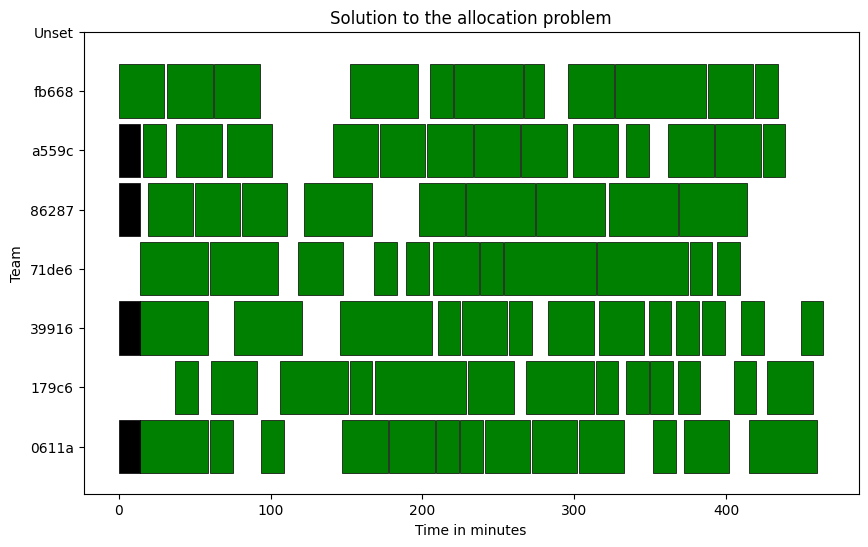

In [4]:
model = AllocationModel(tasks, calendars, same_allocation)
model.set_lexico_objectives([
    model.get_nb_teams_objective(),
    model.get_dispersion_objective()
])

model.solve(time_limit=5) # time limit of 5s for demo

orig_sol = model.get_solution()
fig, ax= model.visualize_solution()

## Disruptions

The above allocation is optimal given the calendars and skills of the working-teams.

However, during the day, a disruption may occur.
Below, we randomly generate a disruption where two teams are affected at the same time.
This can for example happen when two teams are working in the same hangar where a fire-drill is occuring


Adding disruption   team_id  start_unavailable  end_unavailable
0   0611a                189              249
1   39916                189              249


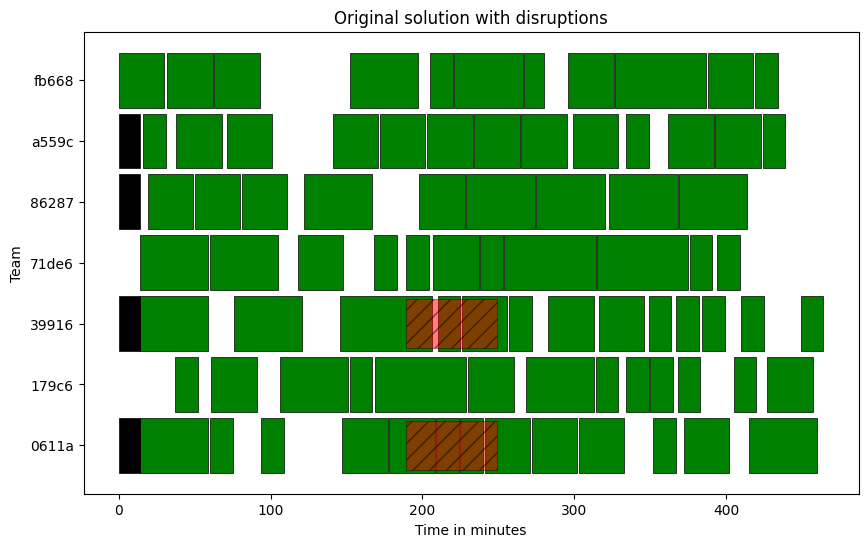

In [5]:
from generator import generate_disruption
import pandas as pd

disruption = generate_disruption(
    num_disruptions=(1,1), num_teams_affected=(2,2), duration=(60,),
    horizon=orig_sol.end.max(), teams=list(orig_sol['assigned_team'].unique()),
    seed = 3
)
model.add_disruption(disruption)

fig, ax = model.visualize_solution_with_disruptions(sol=orig_sol)

In [6]:
model.add_hard_constraint(model.used <= model.used.value()) # cannot use any other teams

if model.solve(): 
    # found solution, unlikely
    new_sol = model.get_solution()
    fig, ax = model.visualize_solution_with_disruptions(sol=new_sol)
else:
    print("Model is now unsatisfiable, could not reallocate tasks")


Objective value: None
Model is now unsatisfiable, could not reallocate tasks


## Generating explanations

### Minimal Unsatisfiable Subset

First, we want to **understand** why there is an issue with the current allocation problem, given the disruptions.
That is, we extract a minimal unsatisfiable subset from the model.

We use the following soft and hard constraints:

These constraints are in conflict:
- Tasks [39 40 41 42 43 45 51] cannot be assigned to the same team
- Task 39 should be allocated to a team
- Task 42 should be allocated to a team
- Tasks [38 39 40 41 42 43 45] cannot be assigned to the same team
- Tasks [38, 51] must be assigned to the same team (team 86287)
- Tasks [40 41 42 43 44 45 51] cannot be assigned to the same team
- Task 51 should be allocated to a team
- Tasks [38, 51] must be assigned to the same team (team 179c6)
- Tasks [38 39 40 41 42 43 45] cannot be assigned to the same team
- Tasks [38, 51] must be assigned to the same team (team 39916)
- Tasks [39 40 41 42 43 45 51] cannot be assigned to the same team
- Task 43 should be allocated to a team
- Task 41 should be allocated to a team
- Task 45 should be allocated to a team
- Tasks [38, 51] must be assigned to the same team (team 0611a)
- Team fb668 cannot be assigned to task 39


Text(0.5, 1.0, 'Set of conflicing tasks')

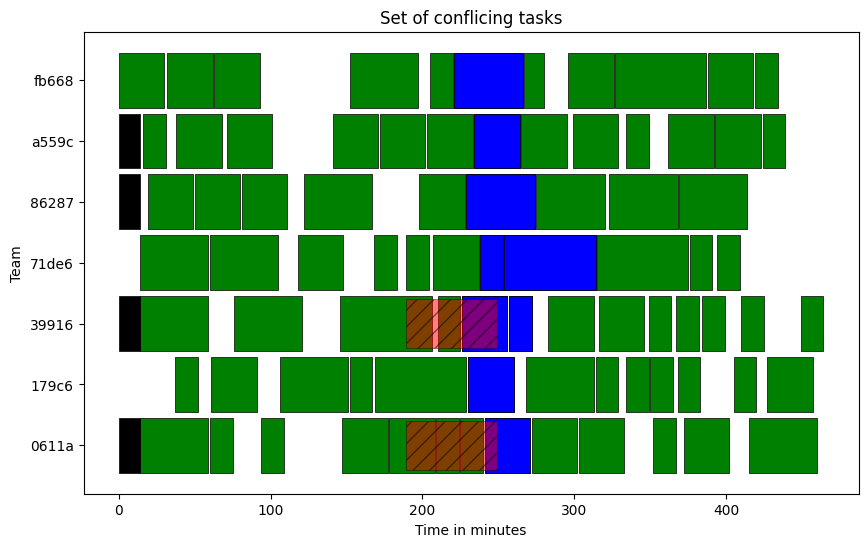

In [7]:
from cpmpy.transformations.normalize import toplevel_list
from cpmpy.tools.explain import mus
from cpmpy.transformations.get_variables import get_variables



subset = mus(soft=model.soft, hard=model.hard, solver="exact")

print("These constraints are in conflict:")
for c in subset:
    print("-", c)
    
fig, ax = model.highlight_tasks(get_variables(subset), sol=orig_sol)
ax.set_title("Set of conflicing tasks")

## Resolving disruptions

Large disruptions can impact the predefined plan in such a way that the set of disrupted tasks cannot be reallocated to other teams.
That is, a task that was originally assigned to a now disrupted team cannot be reassigned as all other compatible teams are already occupied.
This requires the planners to revise the plan, which may involve multiple re-allocation and/or re-scheduling operations.
As this is tedious and time-consuming to do by hand, planners often drop disrupted tasks from the current planning horizon and move it to a next one.

However, in man cases, this is sub-optimal, and we can drop fewer tasks, if we are willing to re-allocate some others as well.


## Minimal Correction subsets

We first try to find a set of tasks that should be **dropped** from the schedule, or release the requirement of two tasks being executed by the same team.

Need to drop these constraints:
- Task 31 should be allocated to a team
- Task 29 should be allocated to a team
- Task 32 should be allocated to a team
- Task 42 should be allocated to a team
- Task 39 should be allocated to a team


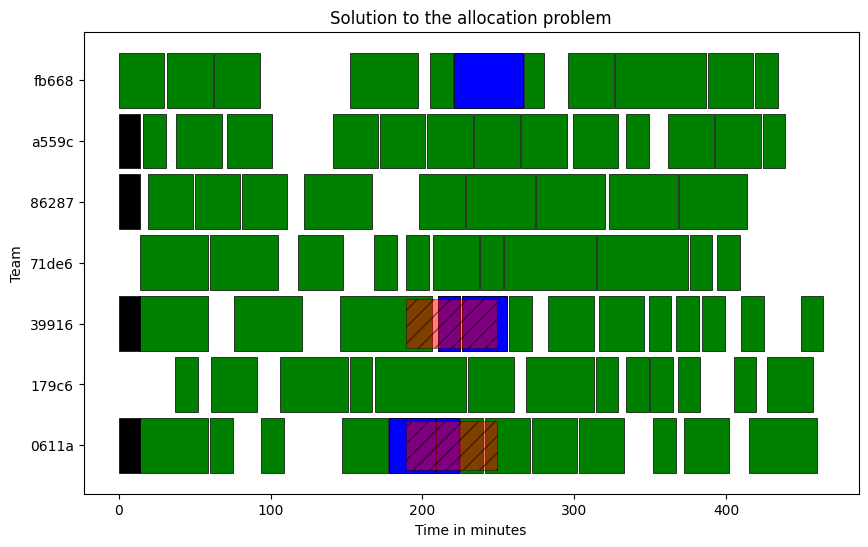

In [8]:
from cpmpy.tools.explain.mcs import mcs_opt

model.add_hard_constraint(model.overlapping_tasks()) # these are hard constraints for the MCS-problem

subset = mcs_opt(model.soft, model.hard, solver="exact")

print("Need to drop these constraints:")
for c in subset:
    print("-", c)

fig, ax = model.highlight_tasks(get_variables(subset), sol=orig_sol)

## Multi-objective feasibility restoration

However, we can do better. Instead of simply dropping tasks, we propose to automatically __repair__ the schedule by allowing slight modifications to the previously found solution.
This is formulated as a lexicographic optimization problem, where we try to optimize several __similarity objectives__.


In [14]:
model = FeasibilityResotorationModel(tasks, calendars, same_allocation, disruption=disruption)
model.set_original_solution(orig_sol)

# # for demo-purposes, cannot go back in time
# model += model.start >= orig_sol['original_start'].astype(int)

In [15]:
model.set_lexico_objectives(*zip(*([
    (model.nb_of_done_tasks(), False),         # Maximize the number of tasks done
    (model.nb_of_reallocated_tasks(), True),   # Minimize the number of re-allocated tasks
    (model.nb_of_shifted_tasks(),True),        # Minimize the number of shifted-tasks
    (model.sum_of_shifted_tasks(), True),      # Minimize the global amount of shifts
    (model.max_of_shifted_tasks(), True)       # Minimize the maximum of shifted tasks
])))

model.solve(time_limit=5)


Objective value: 83
Objective value: 4
Objective value: 20
Objective value: 286
Objective value: 24


True

In [16]:
model.solver_stati

[ExitStatus.OPTIMAL (0.083107 seconds),
 ExitStatus.OPTIMAL (0.049447000000000005 seconds),
 ExitStatus.OPTIMAL (0.047054000000000006 seconds),
 ExitStatus.OPTIMAL (0.062222000000000006 seconds),
 ExitStatus.OPTIMAL (0.06478600000000001 seconds)]

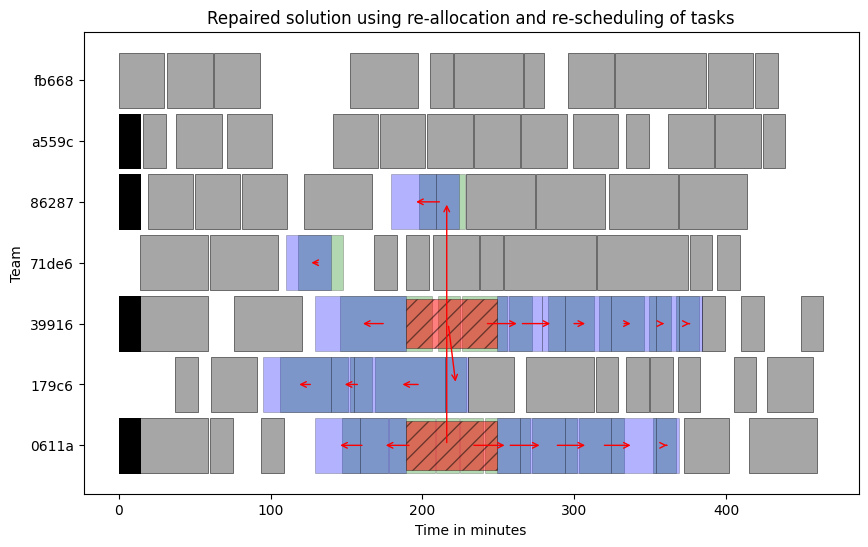

In [17]:
fig, ax = model.visualize_repair()

Objective value: 83
Objective value: 20
Objective value: 4
Objective value: 24
Objective value: 286


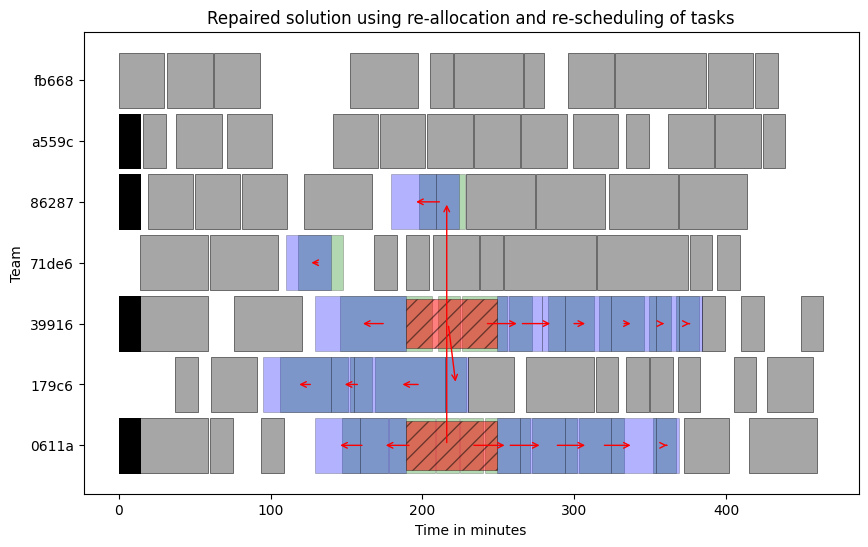

In [18]:
model.set_lexico_objectives(*zip(*([
    (model.nb_of_done_tasks(), False),         # Maximize the number of tasks done
    (model.nb_of_shifted_tasks(),True),        # Minimize the number of shifted-tasks
    (model.nb_of_reallocated_tasks(), True),   # Minimize the number of re-allocated tasks
    (model.max_of_shifted_tasks(), True) ,      # Minimize the maximum of shifted tasks
    (model.sum_of_shifted_tasks(), True),      # Minimize the global amount of shifts
    
])))

assert model.solve(time_limit=5)

fig, ax = model.visualize_repair()